In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from PIL import Image
import os

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input 

2025-11-19 21:35:47.451366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763588147.475349     263 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763588147.482551     263 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Seeds
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0001

In [4]:
# ========================
# 1. LOAD METADATA
# ========================

df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
print(f"Total samples: {len(df)}")

# Label encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
print(f"\nClasses: {list(le.classes_)}")
print(f"\nClass distribution:\n{df['dx'].value_counts()}")

Total samples: 10015

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [5]:
# ========================
# 2. MAP IMAGE PATHS
# ========================

image_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob('/kaggle/input/skin-cancer-mnist-ham10000/*/*.jpg')
}

df['path'] = df['image_id'].map(image_path.get)
df = df.dropna(subset=['path'])
print(f"\nImages found: {len(df)}")


Images found: 10015


In [6]:
# ========================
# 3. SPLIT DATASET
# ========================

train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    stratify=df['label']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['label']
)

print(f"\nSplit sizes:")
print(f"Train: {len(train_df)}")
print(f"Val:   {len(val_df)}")
print(f"Test:  {len(test_df)}")


Split sizes:
Train: 7010
Val:   1502
Test:  1503


In [7]:

# ========================
# 4. CREATE GENERATORS
# ========================

def efficientnet_preprocessing(x):
    """Apply EfficientNet-specific preprocessing"""
    return preprocess_input(x)

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Validation/Test generators
val_test_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing  # ← FIXED!
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='dx',
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nClass indices from generator:")
print(train_generator.class_indices)

Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.

Class indices from generator:
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [8]:
# ========================
# 5. COMPUTE CLASS WEIGHTS CORRECTLY!
# ========================

# Get class distribution
class_counts = train_df['dx'].value_counts()
print(f"\nTraining class distribution:")
print(class_counts)

# Calculate weights with MAXIMUM CAP
total = len(train_df)
class_weight_dict = {}
MAX_WEIGHT = 8.0  # ← CAP at 5× (prevents extreme weights)
MIN_WEIGHT = 0.4  # ← Floor at 0.5× (prevents underweighting)

for class_name, idx in train_generator.class_indices.items():
    count = class_counts[class_name]
    raw_weight = total / (len(train_generator.class_indices) * count)
    
    # Apply caps
    capped_weight = np.clip(raw_weight, MIN_WEIGHT, MAX_WEIGHT)
    
    class_weight_dict[idx] = capped_weight
    print(f"  {class_name}: {count} samples, raw_weight: {raw_weight:.2f}, capped: {capped_weight:.2f}")

print(f"\nFinal class weights: {class_weight_dict}")
print(f"Weight ratio (max/min): {max(class_weight_dict.values())/min(class_weight_dict.values()):.2f}")


Training class distribution:
dx
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64
  akiec: 229 samples, raw_weight: 4.37, capped: 4.37
  bcc: 360 samples, raw_weight: 2.78, capped: 2.78
  bkl: 769 samples, raw_weight: 1.30, capped: 1.30
  df: 81 samples, raw_weight: 12.36, capped: 12.36
  mel: 779 samples, raw_weight: 1.29, capped: 1.29
  nv: 4693 samples, raw_weight: 0.21, capped: 0.30
  vasc: 99 samples, raw_weight: 10.12, capped: 10.12

Final class weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.3, 6: 10.115440115440116}
Weight ratio (max/min): 41.21


In [9]:
# ========================
# 6. BUILD MODEL
# ========================

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(SIZE, SIZE, 3)
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(7, activation='softmax')
], name='SkinCancerClassifier')


I0000 00:00:1763588164.265697     263 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763588164.266397     263 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
# ========================
# 7. COMPILE
# ========================

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()


Model: "SkinCancerClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385,450 (16.73 MB)

 Trainable params: 332,807 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [11]:
# ========================
# 9. CALLBACKS
# ========================

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode="max"
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'model_v1_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]



In [12]:
# ========================
# 10. TRAIN
# ========================
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763588179.631407     298 service.cc:148] XLA service 0x7bd8b80042c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763588179.631440     298 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763588179.631444     298 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763588181.648552     298 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/220 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.1406 - auc: 0.5330 - loss: 3.8141 - precision: 0.1465 - recall: 0.0859   

I0000 00:00:1763588192.409282     298 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.1823 - auc: 0.5577 - loss: 2.9070 - precision: 0.1942 - recall: 0.1020
Epoch 1: val_accuracy improved from -inf to 0.35153, saving model to model_v1_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 170s 663ms/step - accuracy: 0.1825 - auc: 0.5579 - loss: 2.9061 - precision: 0.1944 - recall: 0.1021 - val_accuracy: 0.3515 - val_auc: 0.7124 - val_loss: 1.7284 - val_precision: 0.6313 - val_recall: 0.0752 - learning_rate: 1.0000e-04
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.2904 - auc: 0.6469 - loss: 2.2082 - precision: 0.3290 - recall: 0.1924
Epoch 2: val_accuracy improved from 0.35153 to 0.39015, saving model to model_v1_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 123s 559ms/step - accuracy: 0.2904 - auc: 0.6469 - loss: 2.2085 - precision: 0.3290 - recall: 0.1924 - val_accuracy: 0.3901 - val_auc: 0.7567 - val_loss: 1.6685 - val_precision: 0.4906 - val_recall: 0.1731 - learning_rate: 1.0000e-04
Epoch 3/30
220/220 ━━━━━━━


FINAL EVALUATION
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 603ms/step - accuracy: 0.6654 - auc: 0.9216 - loss: 0.9637 - precision: 0.7692 - recall: 0.5578

Test Loss:     0.9586
Test Accuracy: 0.6667
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 396ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       akiec       0.42      0.49      0.45        49
         bcc       0.51      0.44      0.47        77
         bkl       0.45      0.62      0.52       165
          df       0.13      0.59      0.22        17
         mel       0.31      0.51      0.39       167
          nv       0.95      0.72      0.82      1006
        vasc       0.47      0.82      0.60        22

    accuracy                           0.67      1503
   macro avg       0.46      0.60      0.50      1503
weighted avg       0.77      0.67      0.70      1503



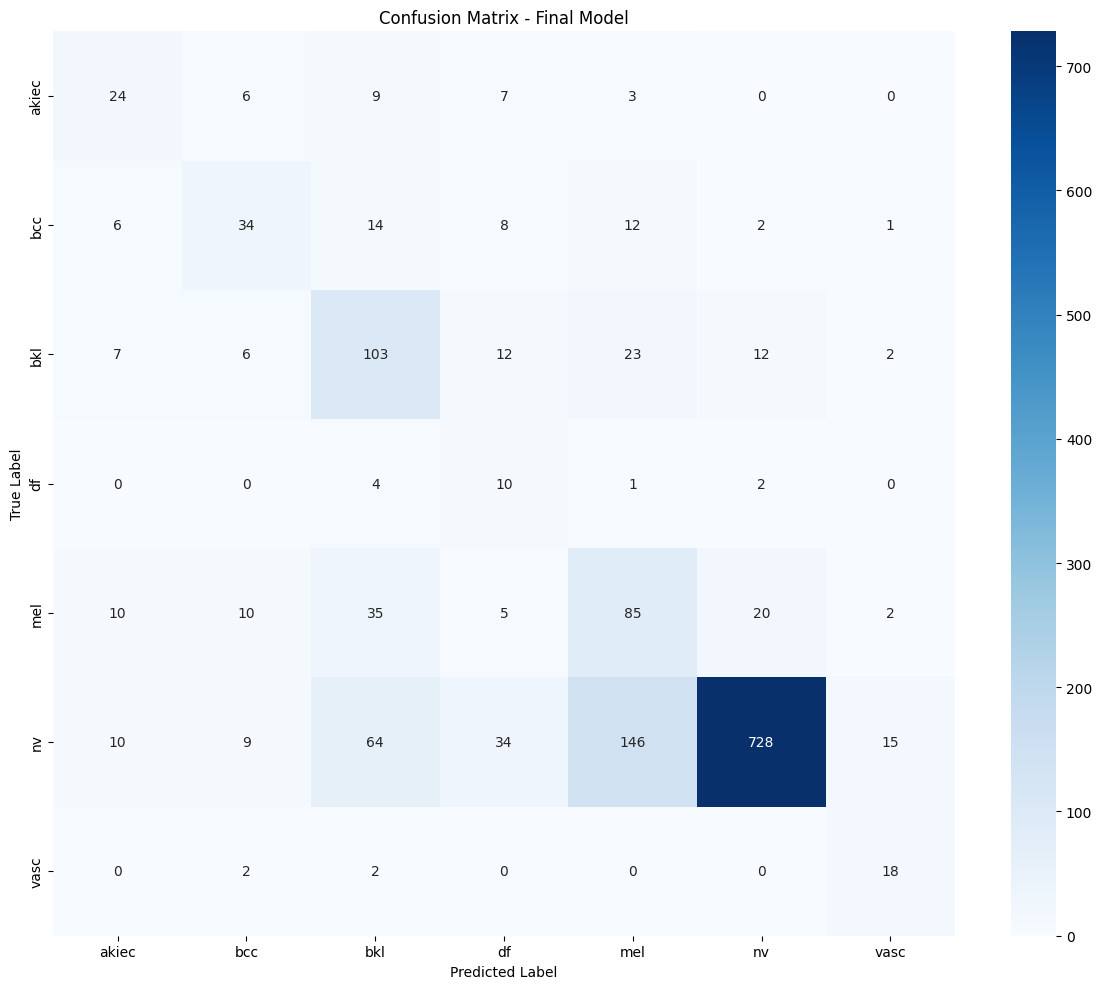


PER-CLASS ACCURACY
akiec : 48.98%
bcc   : 44.16%
bkl   : 62.42%
df    : 58.82%
mel   : 50.90%
nv    : 72.37%
vasc  : 81.82%


In [15]:
# ========================
# 11. EVALUATE
# ========================

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

test_generator.reset()
test_results = model.evaluate(test_generator, steps=len(test_generator))
print(f"\nTest Loss:     {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# Predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
class_names = list(train_generator.class_indices.keys())
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_final.png', dpi=150)
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for class_name, acc in zip(class_names, class_accuracy):
    print(f"{class_name:6s}: {acc:.2%}")


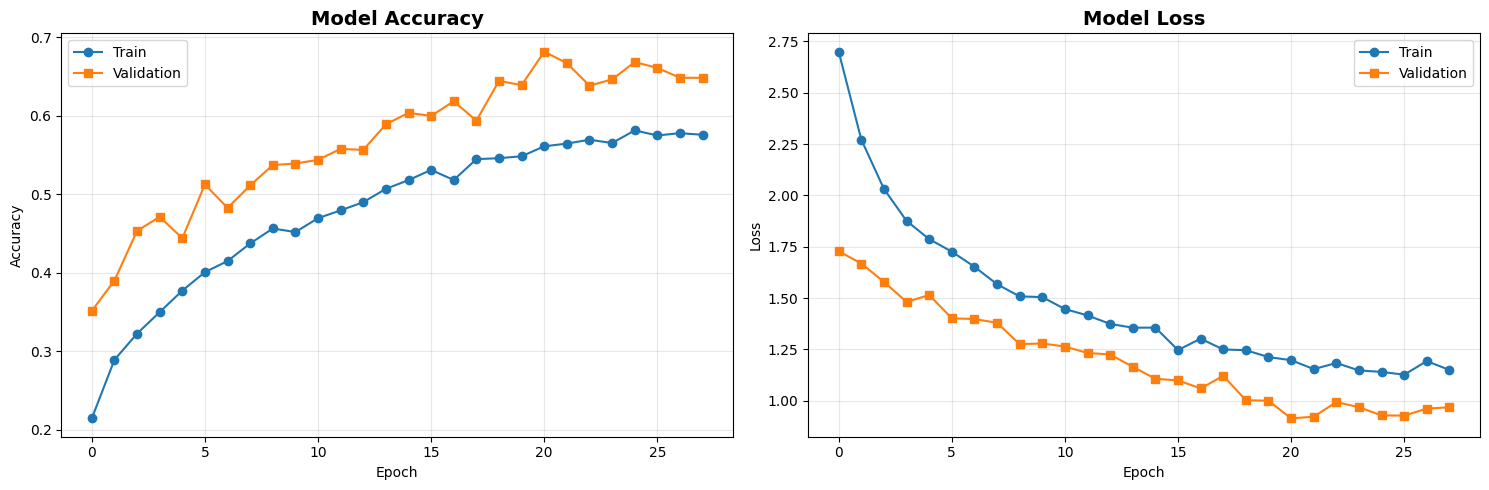

In [16]:
# ========================
# 11. PLOT HISTORY
# ========================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_fixed.png', dpi=150)
plt.show()

In [17]:
# ========================
# 12. SAVE
# ========================

model.save('skin_cancer_model_v1.keras')
print("\n✅ Model saved!")

import pickle
with open('label_encoder.json', 'wb') as f:
    pickle.dump(le, f)
print("✅ Label encoder saved!")


✅ Model saved!
✅ Label encoder saved!


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ========================
# # DIAGNOSTIC 1: Check if images are loading correctly
# # ========================

# print("="*60)
# print("DIAGNOSTIC: Checking image loading...")
# print("="*60)

# # Get one batch from training generator
# x_batch, y_batch = next(train_generator)

# print(f"\nBatch shape: {x_batch.shape}")
# print(f"Labels shape: {y_batch.shape}")
# print(f"Image value range: [{x_batch.min():.3f}, {x_batch.max():.3f}]")
# print(f"Image mean: {x_batch.mean():.3f}")
# print(f"Image std: {x_batch.std():.3f}")

# # Check labels
# print(f"\nLabel distribution in batch:")
# print(np.argmax(y_batch, axis=1))

# # Visualize some images
# fig, axes = plt.subplots(2, 4, figsize=(16, 8))
# for i, ax in enumerate(axes.flat):
#     if i < len(x_batch):
#         ax.imshow(x_batch[i])
#         label_idx = np.argmax(y_batch[i])
#         label_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_idx)]
#         ax.set_title(f"Label: {label_name}")
#         ax.axis('off')
# plt.tight_layout()
# plt.savefig('batch_visualization.png')
# plt.show()

# print("\n✅ If you see proper skin lesion images above, image loading is OK")
# print("❌ If images are black/white/corrupted, we have a loading issue")

# # ========================
# # DIAGNOSTIC 2: Test model on one batch
# # ========================

# print("\n" + "="*60)
# print("DIAGNOSTIC: Testing model prediction on one batch...")
# print("="*60)

# predictions = model.predict(x_batch)
# pred_classes = np.argmax(predictions, axis=1)
# true_classes = np.argmax(y_batch, axis=1)

# print(f"\nPredictions shape: {predictions.shape}")
# print(f"Sample predictions (first 5):")
# for i in range(min(5, len(predictions))):
#     print(f"  Image {i}: Predicted={pred_classes[i]}, True={true_classes[i]}, Confidence={predictions[i].max():.3f}")

# print(f"\nAll predictions in batch: {pred_classes}")
# print(f"Are all predictions the same? {len(set(pred_classes)) == 1}")

# if len(set(pred_classes)) == 1:
#     print("❌ MODEL IS PREDICTING ONLY ONE CLASS!")
# else:
#     print("✅ Model is predicting different classes")

# # ========================
# # DIAGNOSTIC 3: Check class weights
# # ========================

# print("\n" + "="*60)
# print("DIAGNOSTIC: Checking class weights...")
# print("="*60)

# print(f"\nClass weights: {class_weight_dict}")
# print(f"Min weight: {min(class_weight_dict.values()):.2f}")
# print(f"Max weight: {max(class_weight_dict.values()):.2f}")
# print(f"Weight ratio (max/min): {max(class_weight_dict.values())/min(class_weight_dict.values()):.2f}")

# if max(class_weight_dict.values())/min(class_weight_dict.values()) > 50:
#     print("❌ Class weights are too extreme! This might be causing issues.")
# else:
#     print("✅ Class weights look reasonable")

# # ========================
# # DIAGNOSTIC 4: Check base model
# # ========================

# print("\n" + "="*60)
# print("DIAGNOSTIC: Checking base model...")
# print("="*60)

# print(f"Base model trainable: {base_model.trainable}")
# print(f"Base model layers: {len(base_model.layers)}")

# # Check if base model produces reasonable features
# features = base_model.predict(x_batch[:5])
# print(f"\nBase model output shape: {features.shape}")
# print(f"Features mean: {features.mean():.3f}")
# print(f"Features std: {features.std():.3f}")

# if features.std() < 0.01:
#     print("❌ Base model is producing nearly constant outputs!")
# else:
#     print("✅ Base model is producing varied features")